In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits
from boruta import BorutaPy

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
wine_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [6]:
wine_data.shape

(178, 13)

In [7]:
wine_data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [8]:
wine_data.isna().mean()

alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         0.0
dtype: float64

In [9]:
# 1 point
def scale(X):
    np_X = np.array(X)
    X_std = np.std(np_X, axis=0)
    X_std[np.abs(X_std) < np.finfo(float).eps] = 1
    return (np_X - np.mean(np_X, axis=0)) / X_std

In [10]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [11]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy = copy
        self.with_mean = with_mean
        self.with_std = with_std

    def fit(self, X, y=None): #y ignored like in StandardScaler
        
        np_X = np.array(X)
        self.fitted_mean = np.mean(np_X, axis=0) if self.with_mean else 0
        self.fitted_std = np.std(np_X, axis=0) if self.with_std else 1
        self.fitted_std[np.abs(self.fitted_std) < np.finfo(float).eps] = 1 #защита от деления на 0
        
        return self

    def transform(self, X, y=None, copy=None):
        if copy is not None and copy == False and isinstance(X, np.array): #здесь не оч понятно зачем copy в конструкторе и здесь, видимо какой-то рудимент наследования классов
            X = (np.array(X) - self.fitted_mean) / self.fitted_std
        else:
            return (np.array(X) - self.fitted_mean) / self.fitted_std

In [12]:
assert np.allclose(CustomStandardScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [13]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-3.97339625,  0.25433702],
       [-3.73167086,  0.333743  ],
       [20.19347254, -0.22120644],
       ...,
       [ 0.56147922,  4.75980513],
       [-5.0523352 ,  4.71454829],
       [ 4.35935054,  5.41955862]])

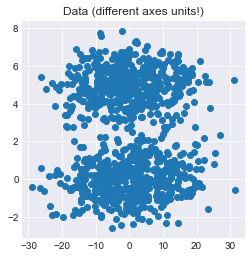

In [14]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

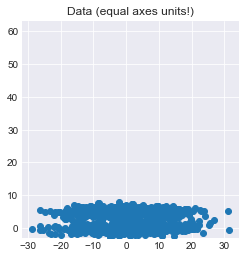

In [15]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

In [16]:
#интерфейс класса воссоздан из sklearn

from sklearn.base import BaseEstimator, TransformerMixin
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
    def __init__(self, feature_range=(0, 1), *, copy=True, clip=False):
        self.copy = copy
        self.feature_range = feature_range
        self.clip = clip

    def fit(self, X, y=None): #y ignored like in StandardScaler
        
        np_X = np.array(X)
        self.fitted_min = np.min(np_X, axis=0)
        self.fitted_max = np.max(np_X, axis=0)
        
        return self

    def transform(self, X):
        old_range = self.fitted_max - self.fitted_min
        old_range[np.abs(old_range) < np.finfo(float).eps] = 1
        new_range = self.feature_range[1] - self.feature_range[0]
        
        if self.copy == False and isinstance(X, np.array):
            X = (np.array(X) - self.fitted_min) / (old_range)
            X = X * new_range + self.feature_range[0]
        else:
            return (np.array(X) - self.fitted_min) * new_range  / old_range + self.feature_range[0]

Это мой собственный assert. Захотелось этот класс тоже реализовать хоть задание и не просит

In [17]:
data_min_max = CustomMinMaxScaler().fit_transform(data)
assert np.allclose(data_min_max, MinMaxScaler().fit_transform(data))

Для скаттерплота выбрала одной из осей proline - у него самые высокие значения

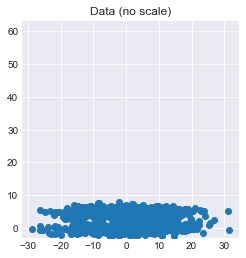

In [18]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (no scale)')

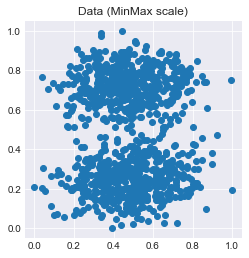

In [19]:
plot_scatter(data_min_max[:, 0], data_min_max[:, 1], auto_scaled=False , title='Data (MinMax scale)')

### StandardScaler (0.5 point)

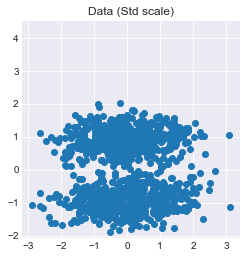

In [20]:
data_std = CustomStandardScaler().fit_transform(data)
plot_scatter(data_std[:, 0], data_std[:, 1], auto_scaled=False , title='Data (Std scale)')

После масштабирования в обоих скейлерах данные выглядят соразмерно

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


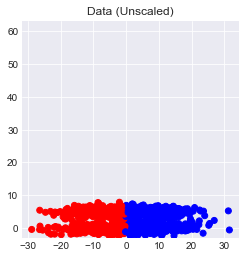

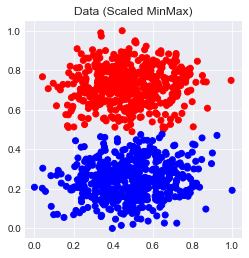

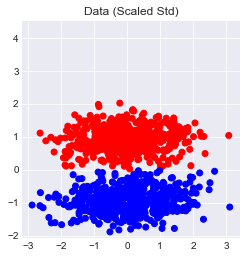

In [21]:
from sklearn.cluster import KMeans

kmeans_unscaled = KMeans(n_clusters=2, random_state=42).fit(data)
kmeans_scaled_min_max = KMeans(n_clusters=2, random_state=42).fit(data_min_max)
kmeans_scaled_std = KMeans(n_clusters=2, random_state=42).fit(data_std)

#equal_sc
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title='Data (Unscaled)', clusters=kmeans_unscaled.predict(data))
plot_scatter(data_min_max[:, 0], data_min_max[:, 1], auto_scaled=False, title='Data (Scaled MinMax)', clusters=kmeans_scaled_min_max.predict(data_min_max))
plot_scatter(data_std[:, 0], data_std[:, 1], auto_scaled=False, title='Data (Scaled Std)', clusters=kmeans_scaled_std.predict(data_std))

## Exercise  3 - Preprocessing Pipeline (2 points)

In [22]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [23]:
wine_labels.unique()

array([0, 1, 2])

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

def fit_evaluate(clf, X_train, y_train, X_test, y_test, ax=None):
    clf.fit(X_train, y_train)
    cm = confusion_matrix(y_test, clf.predict(X_test), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) #здесь реализацию авторов сменила на новую, та была deprecated
    disp.plot(ax=ax)
    disp.figure_.suptitle("Confusion Matrix")
    # plt.show() - закомментила, чтобы выводить subplots
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [25]:
pipeline_unscaled = make_pipeline(LogisticRegression(solver='liblinear', penalty='l1', random_state=42))
pipeline_std_scaled = make_pipeline(CustomStandardScaler(), LogisticRegression(solver='liblinear', penalty='l1', random_state=42))
pipeline_feat_selected = make_pipeline(CustomStandardScaler(), SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', random_state=42), max_features=5), LogisticRegression(solver='liblinear', penalty='l1', random_state=42))

In [26]:
from sklearn import set_config
set_config(display="diagram")

display(pipeline_unscaled)
display(pipeline_std_scaled)
display(pipeline_feat_selected)

Pipeline(steps=[('logisticregression',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

Pipeline(steps=[('customstandardscaler', CustomStandardScaler()),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

Pipeline(steps=[('customstandardscaler', CustomStandardScaler()),
                ('selectfrommodel',
                 SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                              random_state=42,
                                                              solver='liblinear'),
                                 max_features=5)),
                ('logisticregression',
                 LogisticRegression(penalty='l1', random_state=42,
                                    solver='liblinear'))])

Unscaled Train accuracy = 0.967741935483871
Unscaled Valid accuracy = 0.9814814814814815

Scaled Train accuracy = 1.0
Scaled Valid accuracy = 0.9814814814814815

Features Selected Train accuracy = 0.9838709677419355
Features Selected Valid accuracy = 1.0



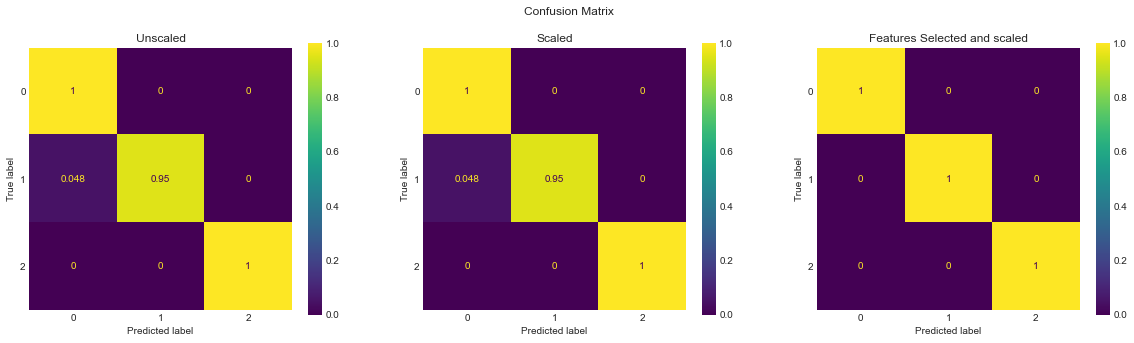

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

train_acc, test_acc = fit_evaluate(pipeline_unscaled, wine_train, wine_labels_train, wine_val, wine_labels_val, axs[0])
axs[0].grid(False)
axs[0].set_title('Unscaled')
print(f'Unscaled Train accuracy = {train_acc}')
print(f'Unscaled Valid accuracy = {test_acc}\n')

train_acc, test_acc = fit_evaluate(pipeline_std_scaled, wine_train, wine_labels_train, wine_val, wine_labels_val, axs[1])
axs[1].grid(False)
axs[1].set_title('Scaled')
print(f'Scaled Train accuracy = {train_acc}')
print(f'Scaled Valid accuracy = {test_acc}\n')

train_acc, test_acc = fit_evaluate(pipeline_feat_selected, wine_train, wine_labels_train, wine_val, wine_labels_val, axs[2])
axs[2].grid(False)
axs[2].set_title('Features Selected and scaled')
print(f'Features Selected Train accuracy = {train_acc}')
print(f'Features Selected Valid accuracy = {test_acc}\n')

In [28]:
print(f"Процент нулевых коэф-тов LR без масштабирования = {np.sum(pipeline_unscaled.get_params()['logisticregression'].coef_ == 0) / 3 / wine_train.shape[1] * 100}%")
print(f"Процент нулевых коэф-тов LR с масштабированием = {np.sum(pipeline_std_scaled.get_params()['logisticregression'].coef_ == 0) / 3 / wine_train.shape[1] * 100}%")
print(f"Процент нулевых коэф-тов LR с масштабированием и выбором признаков = {(5*3 + np.sum(pipeline_feat_selected.get_params()['logisticregression'].coef_ == 0)) / 3 / wine_train.shape[1] * 100}%")

Процент нулевых коэф-тов LR без масштабирования = 41.02564102564102%
Процент нулевых коэф-тов LR с масштабированием = 43.58974358974359%
Процент нулевых коэф-тов LR с масштабированием и выбором признаков = 48.717948717948715%


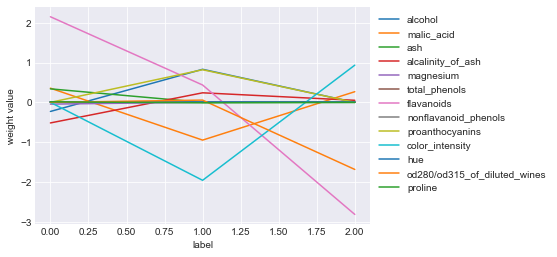

In [29]:
plt.plot(wine_labels.unique(), pipeline_unscaled['logisticregression'].coef_);
plt.legend(wine_train.columns, bbox_to_anchor=(1, 1));
plt.ylabel('weight value');
plt.xlabel('label');

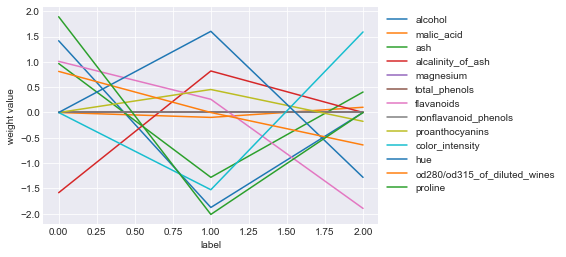

In [30]:
plt.plot(wine_labels.unique(), pipeline_std_scaled['logisticregression'].coef_);
plt.legend(wine_train.columns, bbox_to_anchor=(1, 1));
plt.ylabel('weight value');
plt.xlabel('label');

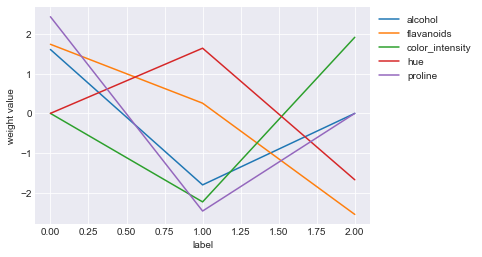

In [31]:
plt.plot(wine_labels.unique(), pipeline_feat_selected.get_params()['logisticregression'].coef_);
plt.legend(wine_train.columns[pipeline_feat_selected['selectfrommodel'].get_support(indices=True)], bbox_to_anchor=(1, 1));
plt.ylabel('weight value');
plt.xlabel('label');

Как было видно выше у wine_data большая часть признаков порядка \\(10^1\\), 1 признак порядка \\(10^2\\) и 1 признак порядка \\(10^3\\)
Итак, рассмотрим 3 случая:
* **Данные не масштабируются**. Точности train и test - 0.96 и 0.98 соответственно. И это случай с самыми худшими точностями. Выходит так из-за того что модель приписывает бОльшие значимости признакам с бОльшими значениями
* **Данные масштабируются (Std scale)**. Точность на Train выросла до 1. Точность на Valid осталась прежней.
* **Данные масштабируются (Std scale) и происходим выбор признаков**. Точность на train выше, чем на данных без масштабирования, но меньше, чем без выбора фич. Точность Valid стала 1. Здесь удалось использовать на входе модели всего 5 признаков после SelectFromModel и как видно на крайнем правом графике ещё часть коэффицентов занулилась при повторном обучении той же регрессии.

# Вывод:
Худшие точности достигаются без масштабирования данных. Точности на масштабированных данных до и после выбора фич практически одинаковые, однако выбор фич позволяет значительно снизить вычислительную сложность модели и зависимость от части признаков, что делает модель более интерпретируемой

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [32]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [33]:
wine_data_np = np.array(wine_data)
wine_data_std = (wine_data_np - np.mean(wine_data_np, axis=0)) / np.fmax(np.std(wine_data_np, axis=0), np.finfo(float).eps)

def get_cov_mtrx(x):
    return (x.T @ x) / max((x.shape[0] - 1), 1)
    
S = get_cov_mtrx(wine_data_std)

If your code is correct, the following assert should be Ok.

In [34]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [35]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return -(x.T @ S @ x)
    

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return np.linalg.norm(x) - 1

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(wine_data.shape[1]) # your code: initial vector to start optimization

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x
x0 @ S @ x0

4.7324370201423065

Hurray! We have first vector! Let's do another one.

In [36]:
def orthogonality_constraint(x):
    return x @ x0
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 = np.zeros(wine_data.shape[1]) # your code: initial vector to start optimization


sol = minimize(objective, 
               x1, 
               constraints = [con1, con2]
              )

x1 = sol.x
x1@S@x1

2.5110809431059535

If your solution is correct, the following asserts should be Ok.

In [37]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

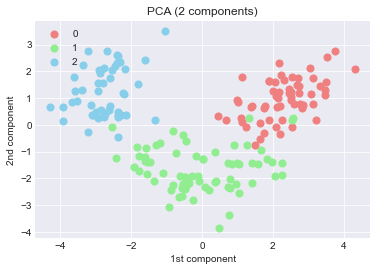

In [38]:
pc1 = wine_data_std @ x0
pc2 = wine_data_std @ x1

color_dict = {0: 'lightcoral', 1: 'lightgreen', 2: 'skyblue'}

for label in np.unique(wine_labels):
    ix = np.where(wine_labels == label)[0]
    plt.scatter(pc1[ix], pc2[ix], c = color_dict[label], label = label, s = 50)
    
plt.legend()
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('PCA (2 components)');

# Вывод:
На визуализации стало заметно как хорошо разделяются на 3 класса нормализованные данные в двумерном пространстве. Понятно, что для разделения на классы двух измерений достаточно. Нам удалось понизить размерность с 13 до 2х признаков, это ли не прекрасно)

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [39]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

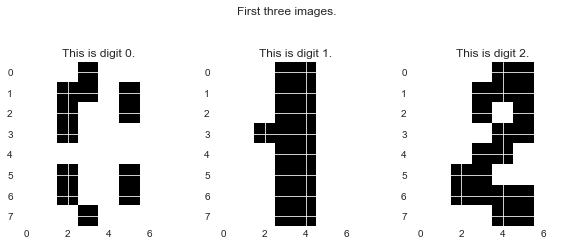

In [40]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [42]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

0.9938271604938271


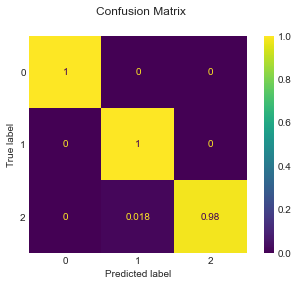

In [43]:
clf = RandomForestClassifier(max_depth=13)

train_acc, test_acc = fit_evaluate(clf, X_train, y_train, X_val, y_val)
plt.grid(False)

acc = test_acc
print(acc)

In [44]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [45]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


In [46]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x21211D09C40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x21211D09C40)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

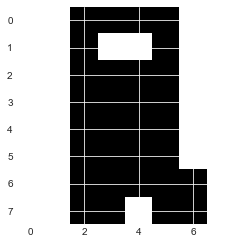

In [47]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

0.9938271604938271


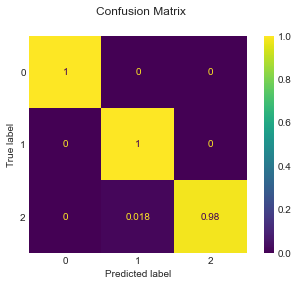

In [48]:
clf = RandomForestClassifier(max_depth=13, random_state=42)

X_train_filtered = feat_selector.transform(np.array(X_train))
X_val_filtered = feat_selector.transform(np.array(X_val))

train_acc, test_acc = fit_evaluate(clf, X_train_filtered, y_train, X_val_filtered, y_val)
plt.grid(False)

acc = test_acc
print(acc)

In [49]:
assert acc > 0.99

In [50]:
print(f'Размерность с Борутой снижена с {X_train.shape[1]} до {X_train_filtered.shape[1]} признаков')

Размерность с Борутой снижена с 64 до 31 признаков


# Вывод:
С борутой мы микроскопически подняли точность (правда это только с этим random_seed), на самом деле точность особо не изменилась. Но основной бонус, снижение признакового пространства практически в 2 раза! Это крутой результат. Видимо, чтоб распознать число достаточно каких-то ключевых пискелей, задающих ход линии числа

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market